## Code for Hyperparameter Tuning and Model Selection ##

### Import Statements ###

In [1]:
import scipy.io as sio
from scipy import signal
import inspect
import os
import contextlib
import mne
import pandas as pd
from pandas.plotting import table
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from timeit import default_timer as timer
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

In [2]:
#SVM often fails to converge using csp, even after data regularization. This causes the printing of ~600 warnings. This supresses that
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Method and Constant Definitions ###

#### DATA PRE-PROCESSING FUNCTIONS ####
Below are our data pre-processing functions. The first block comment describes the process for adding a new data pre-processing method to the testing pipeline. The pre-processing method we currently test are:
- MNE CSP dimensionality redcution method
- Taking a simplified Lateralized Readiness Potential (channel 24 minus channel 8). We refer to this as LRP.

In [3]:
#function-type alias for use in type hints
function = type(lambda x: x)

##### Low Pass Filter Logic #################

def our_lowpass(data, freq=35):
    filt_data = data
    b, a = signal.butter(6, freq, 'low', analog = False, fs = 1000)
    for i in range(len(data)):
        filt_data[i] = signal.filtfilt(b, a, data[i])
    return filt_data


######################## Data Dimensionality Reduction Methods ##############################################################
'''
    Any additional dimensionality reduction method can be added to the testing pipeline provided that it follows the below rules:
        1. It must take a numpy array named X of shape (channels, samples, trials) as the first parameter. No target labels may
            be present in this array.
        2. All other parameters must be named parameters with default values. If the dimensinoality reducing transformation must be fit using target label data,
            this parameter must be a numpy array named y of dimension (trials,).
        3. Return value must be a numpy array of dimensions (trials, n) where n>0. Return value may be None if target label data is provided (used to fit data transforms)
        4. The dimensionality reduction method must be added to the dictionary titled reduction_methods, located in DATA PREPROCESSING CONSTANTS
'''

def sliding_window(X:np.ndarray, window_length:int, step_size:int, step:int):
    '''
    Functionality: Gives a subset of given X data matrix corresponding to the sample window specified by the parameters
    Params:
        X: Numpy array of shape (channels, samples, trials). Contains EEG sample data for each trial
        window_length: Number of samples per window
        step_size: Stride-length of the sliding window
        step: Stride step number of current sliding window
    Returns:
        Numpy array of shape (channels, window_length, trials). The first sample in the return value will correspond to the 
            step_size*step th sample of X, and the last sample will correspond to the step_sample*step+window_length th index
            of X. if step_sample*step+window_length is out of bounds for X, then the final index will correspond to the final 
            sample in X
    '''
    w_start_idx = step_size*step
    w_end_idx = min( [X.shape[1]-1, w_start_idx + window_length] )
    return X[:, w_start_idx:w_end_idx, :]

#################### Laterized Readiness Potential Logic
def calc_lrp(X:np.ndarray): 
    '''
    Functionality: Obtains Laterized Readiness Potential corresponding to the data matrix X
    Params: 
        X= Numpy array of shape (channels, samples, trials). Contains EEG sample data for each trial
    Returns:
        Numpy array of shape (trials, samples) where the samples index contains LRP for each sample time.
    '''
    X_reduced = X[23,:,:] - X[7,:,:]
    return X_reduced.T


######################## MNE CSP transform logic

#Constants to save last-trained CSP objects
# and dictionary of saved CSP objects for later use
csp_transformer = mne.decoding.CSP()
csp_dict = {}

def csp_transform(X:np.ndarray, y:np.ndarray=None, n_components:int=None, transformer_label:str=None, only_train_on_new_label=False):
    '''
    Functionality: Either fits a CSP transform object to X and y data with specified number of components and caches the CSP object, or transforms X data matrix using MNE CSP.
    Params:
        X= Numpy array of shape (channels, samples, trials). Contains EGG sample data for each trial.
        y= binary Numpy array of shape (trials), or None. Contains labels corresponding to left or right button clicks. If provided, return value will be None and a MNE CSP object will
            be fit on the X,y data provided. If not provided or None, the last-fitted CSP object will be used to transform X into a numpy array of shape (trials, n_components*), where n_components*
            is the parameter n_components given when the CSP object was fit. Default is None.
        n_components= integer or None. Number of components to remain after CSP transform. If not provided or None, default of n_components=4 will be used. Parameter ignored if y=None.
        transformer_label: string or None. If y is provided, then function will return None and newly trained CSP object will be saved to a dictionary csp_dict. If y is None, then function will return
            transformed X matrix transformed by the CSP object saved with label transformer_label. If None, behavior will be same as outlined in the y parameter specification.
        only_train_on_new_label: Boolean. If either y or transformer_label is not provided parameter will be ignored. Else, if True, csp_dict will be checked for transformer_label. If found, a new CSP
            object will not be re-fit and function will return None. If False or transformer_label is not a key in csp_dict, functionality will revert to that outlined in transformer_label parameter specification.
            Setting this parameter to True can result in reductions in runtime, since fitting a CSP model is computationally expensive.
    Returns:
        if y is provided: None
        if y is None: A new X data matrix of shape (trials, n_components*), where n_components* is the parameter n_components given when the CSP object was fit
    '''
    global csp_transformer
    global csp_dict
    dim = X.shape
    X_shaped = X.reshape(dim[2], dim[0], dim[1])
    #if training data is given
    if y is not None:
        #if instructed to only train on new transformer label and transformer label is not new then exit function
        if only_train_on_new_label and transformer_label in csp_dict:
            return None
        #if n_components is specified, initialize CSP with those components, otherwise use default n_component values
        if n_components is not None:
            csp_transformer = mne.decoding.CSP(n_components)
        else:
            csp_transformer = mne.decoding.CSP()
        #Supress lengthy print statements from CSP and train
                    #WARNING: This will supress all warnings and errors. ONLY USE IF CODE HAS BEEN TESTED
                    # AND IT IS KNOWN THAT IT WILL NOT CRASH DURING THE FITTING PROCEDURE 
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            csp_transformer.fit(X_shaped, y)
        if transformer_label is not None:
            csp_dict[transformer_label] = csp_transformer
        return None        
    else:
        #Supress lengthy print statements from CSP and transform data
                    #WARNING: This will supress all warnings and errors. ONLY USE IF CODE HAS BEEN TESTED
                    # AND IT IS KNOWN THAT IT WILL NOT CRASH DURING THE FITTING PROCEDURE 
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            if transformer_label is not None:
                if transformer_label not in csp_dict:
                    warnings.warn('No CSP object matching label {} found in cache'.format(transformer_label), UserWarning)
                    return None
                return csp_dict[transformer_label].transform(X_shaped)
            else:
                return csp_transformer.transform(X_shaped)

    
######################################### Data Formatting Logic ################################################
scaler = StandardScaler()
def Format(X:np.ndarray, 
           y:np.ndarray,  
           reduction_method:function, 
           reduction_method_args=None,
           trials_in_A:int=100,
           normalize=False,
           fit_standard_scaler=True):
    '''
    Functionality: Prepares data for analysis by splitting input data into A and B conditions, and applying a dimensionality 
        reduction to the data in each condition.
    Params:
         X= Numpy array of shape (channels, samples, trials[A,B]). Contains EGG sample data for each trial.
         y= binary Numpy array of shape (trials[A,B])
             reduction_method: A data dimensionality reduction method as outlined in the method definitions above.
         reduction_method_args: A dictionary with key:value pairs corresponding to parameter names and parameter values for 
             reduction_method. This dictionary should not contain ('X':X), as the X data matrix is automatically fed to the reduction method.
        trials_in_A: Number of trials in the A test condition. Parameter is used to split X and y into separate A and B partitions.
        normalize: Boolean. If true, data will be normalized according to the value of the global scaler variable defined above.
        fit_standard_scaler: If true, the scaler global variable will be fit on the post-reduction_method data, then the data will be normalized
            according to this fit scaler. Parameter is ignored if normalize=False. WARNING: only set to false if it is known that scaler has most
            recently been fit on data of the same shape as reduction_method(X). Otherwise function will throw error.
    Returns: Pair A_dict, B_dict of:
        A_dict: Dictionary with keys "X" and "y". "X" contains dimensionality-reduced data corresponding to the A test conditon. y contains target label data
            corresponding to A test condition.
        B_dict: Dictionary with keys "X" and "y". "X" contains dimensionality-reduced data corresponding to the B test conditon. y contains target label data
            corresponding to B test condition.
    '''
    global scaler
    if type(reduction_method_args) == dict:
        X_reduced = reduction_method(X, **reduction_method_args)
    elif type(reduction_method_args) == list:
        X_reduced = reduction_method(X, *reduction_method_args)
        
    else:
        X_reduced = reduction_method(X)
    if normalize:
        if fit_standard_scaler:
            scaler.fit(X_reduced)
        X_reduced = scaler.transform(X_reduced)
    condition_A_data_dict, condition_B_data_dict = condition_split(X_reduced, y, trials_in_A)
    return condition_A_data_dict, condition_B_data_dict

def condition_split(X:np.ndarray, y:np.ndarray, trials_in_A:int):
    #hepler function for Format. Returns X and y partitioned into A and B conditions. trials_in_A is used to 
    # determine location of the partition
    AX, BX = X[:trials_in_A], X[trials_in_A:]
    Ay, By = y[:trials_in_A], y[trials_in_A:]
    A_dict = {'X': AX, 'y': Ay}
    B_dict = {'X': BX, 'y': By}
    return A_dict, B_dict


#### DATA PRE-PROCESSING CONSTANTS ###
The below constants define which data pre-processing methods will be included in the hyperparameter tuning and model evaluation.

In [4]:
#data dimensionality reduction methods to opitmize for
    #note that csp transform will use n_components=4 for model hyperparameter tuning
    # n_components will be finalized in another round of cross-validation
    # runtime to validate all combinations of n_components and model hyperparameters too long
    # for our current computational capacity so this will have to do
reduction_methods = {
    'lrp': calc_lrp,
    'csp': lambda X: csp_transform(X, transformer_label='hyperparam_tune')
}

#### HYPERPARAMETER TUNING CONSTANTS ####

Below are our hyperparameter tuning constants. They describe which classifiers will be included in the hyperparameter tuning and model evaluations. The first block comment describes the process for adding a new classification model to the testing pipeline. The classifiers we are currently testing are:
- LDA
- SVM
- Random Forest
- AdaBoost

In [27]:
'''
    Any Classifier may be added to the testing pipeline given that it follows the following Rules:
        1. It implements sklearn's classifier interface
        2. Hyperparameters which need to provided or tuned must be defined as in the dictionaries below.
            If no tuning is needed for a particular hyperparameter but it must be provided, include it in the 
            hypeparameter dictionary as a single element list.
        3. The bare classifier (with no hypeparameters provided) is added a value to the clfs dictionary
        4. The hyperparameter dictionary for the classifier is added as a value to the params dictionary. The key
            for the hyperparameter dictionary must be the same key used for the bare classifier in clfs.
'''

#Hyperparameter dictionaries for use in grid search
ada_params = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [x/20 for x in range(1,21)],
    'algorithm': ['SAMME', 'SAMME.R']
}

rf_params = {
    'n_estimators': [25, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': (None, 10, 50, 100),
    'min_samples_split': [2, 4, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ('auto', 'sqrt', 'log2', None),
    'min_impurity_decrease': (0.0, 0.5)
}

lda_params = {
    'solver': ['svd','lsqr','eigen'],
    'shrinkage': ['auto',None],
}

svm_params = {
    'C': np.logspace(-3,2,6),
    'kernel': ['linear','poly','rbf','sigmoid'],
    'degree': [2,3,4],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3,3,6)),
    'shrinking': [True, False],
    'max_iter': [1000]
}

#Dictionary of classifiers and hyperparemeter selections
clfs = {
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LDA': LDA(),
    'SVM': SVC()
}

params = {
    'RandomForestClassifier': rf_params,
    'AdaBoostClassifier': ada_params,
    'LDA': lda_params,
    'SVM': svm_params
}



#### HYPERPARAMETER TUNING FUNCTIONS ####

In [6]:

def tune_multiple_models(data_matrix:np.ndarray, 
                         data_labels:np.ndarray, 
                         clf_list:list=[key for key in clfs], 
                         reduction_method_list:list=[key for key in reduction_methods],
                         trials_in_A=100):
    '''
    Functionality: Tunes hyperparameters for all combinations of classifier and data-preprocessing methods provided.
    Params:
        data_matrix: Numpy array of shape (channels, samples, trials)
        data_labels: Numpy array of target labels of shape (samples,)
        clf_list: List of strings which correspond to keys in the clfs dictionary
        reduction_method_list: List of strings which correspond to keys in the reduction_methods dictionary
    Returns:
        List of return values from tune_model (see below)
    Depends on Globals:
        reduction_methods,
        clfs
    '''
    tuned_models = []
    for clf_ident in clf_list:
        for reduction_method_ident in reduction_method_list:
            X = np.array(data_matrix, copy=True)
            y = np.array(data_labels, copy=True)
            #prepare CSP reduction method data partition
            if reduction_method_ident == 'csp':
                X_csp = X[:,:,trials_in_A-20:trials_in_A+20]
                y_csp = y[trials_in_A-20:trials_in_A+20]
                X = np.concatenate((X[:,:,:trials_in_A-20],X[:,:,trials_in_A+20:]), axis=-1)
                y = np.hstack((y[:trials_in_A-20],y[trials_in_A+20:]))
                csp_transform(X_csp, y_csp, transformer_label='hyperparam_tune', only_train_on_new_label=True)
            tuned_models.append(tune_model(X, 
                                           y, 
                                           clf_ident, 
                                           reduction_method_ident) )
    return tuned_models

def tune_model(data_matrix:np.ndarray, 
               data_labels:np.ndarray,
               clf_ident:str, 
               reduction_method_ident:str):
    '''
    Functionality: Tunes hyperparameters for a given classifier on data preprocessed by given dimensionality reduction method
    Params:
        data_matrix: Numpy array of shape (channels, samples, trials)
        data_labels: Numpy array of target labels of shape (samples,)
        clf_ident: string which corresponds to a key in the clfs dictionary
        reduction_method_ident: string which correspond to a key in the reduction_methods dictionary
    Returns:
        Dictionary of key:value pairs of
                "clf_type": string key entry to a classifier in the clfs dictionary
                "reduction_method": string key entry to a data preprocessing method in the reduction_methods dictonary
                "clf": Fitted GridSearchCV object who's classifier corresponds to "clf_type" and which was fit to data preprocessed by
                    "reduction_method"
    '''
    #bring needed global variables into namespace
    global scaler_hyperparam
    global clfs
    global reduction_methods
    global params
    #Let user know which model is being tuned
    print('Hyperparameter tuning', clf_ident, 'on data pre-processed by dimensionality reduction method {}.'.format(reduction_method_ident))
    #obtain classifier, hyperparameters from corresponding dictionaries
    clf = clfs[clf_ident]
    hyperparam_dict = params[clf_ident]
    reduction_method = reduction_methods[reduction_method_ident]
    #determine if data should be normalized
    normalize = clf_ident=='SVM'
    #apply dimensionality reduction to data and split into different experiment classes
    #For model hyperparameter tuning, do not separate A and B conditions
    _, data_dict = Format(data_matrix, data_labels, reduction_method, trials_in_A=0, normalize=normalize, fit_standard_scaler=True)
    #tune model
    X = data_dict['X']
    y = data_dict['y']
    clf_mod = GridSearchCV(clf, hyperparam_dict, n_jobs=7)
    start_time = timer()
    clf_mod.fit(X,y)
    stop_time = timer()
    print('\t Done. Wall time elapsed: {}'.format(timedelta(seconds=stop_time-start_time)))
    return {
        'clf_type': clf_ident,
        'reduction_method': reduction_method_ident,
        'clf': clf_mod,
        'hyperparam_tuning_time': timedelta(seconds=stop_time-start_time)
    }




#### CSP N_COMPONENTS TUNING FUNCTION ####

CSP requires specifying how many features will remain in the data after the transformation via a parameter named n_components. Per the documentation on CSP, this number should be set via K-fold cross validation. Below is our logic to find the appropriate n_components.

In [29]:
    
def tune_csp_args_cv(csp_models:list, 
                     X:np.ndarray,
                     y:np.ndarray,
                     n_component_list=list(range(1,64)), 
                     n_folds=5,
                     memoize_csp_mod=True):
    '''
    Functionality: Selects number of CSP components via K-fold cross validation for all models provided.
    Params:
        csp_models: List of dictonaries as outputted by tune_model (see above). All models where "reduction_method" is not 
            the key to value "csp" will be ignored (that is, all models which where not hyperparameter tuned for data transformed by CSP)
        n_component_list: List of integers corresponding to n_components for a CSP transformation.
        X: Numpy array of shape (channels, samples, trials)
        y: Numpy array of target labels of shape (trials,)
        n_folds: K to use in K-fold cross validation.
        memoize_csp_mod: Boolean. Used for runtime optimization. Setting to true can result in large reductions in rutime at the expense of greater
             memory consumption. If true, each CSP model corresponding to a particular n_component and training dataset will be saved to a cache, 
             and all subsequent trials using the same training data and n_components will query the cache instead of fitting a CSP model
             on the training data again.
    Returns:
        input csp_models list mutated as specified in Side Effects
    Side Effects:
        Every classfier in csp_models will be mutated as follows:
            If the classifier was not hypeparameter tuned on data preprocessed by MNE CSP, no side effects.
            Otherwise, this classifier dictionary will have the property that classfier['reduction_method_args']['n_components'] = best_n.
                where best_n corresponds to the number of CSP components chosen by K-fold cross validation.
            
    '''
    #bring StandardScaler used for SVM into namespace
    global scaler
    #print CSP n_component tuning config. settings
    if memoize_csp_mod:
        print('CSP n_component tuning using memoization. First classifier will take longer to tune as memoization cache is filled.')
    #begin tuning
    for clf_dict in csp_models:
        #only tune models with hyperparameters optimized for CSP
        if clf_dict['reduction_method']!='csp':
            continue
        print('Tuning CSP n_components for {}'.format(clf_dict['clf_type']))
        start_time = timer()
        #ensure reduction_method_args entry is in clf_dict for saving tuned n_components
        if 'reduction_method_args' not in clf_dict:
            clf_dict['reduction_method_args'] = {}
        #initialize classification model to tune
        params = clf_dict['clf'].best_params_
        mod = clf_dict['clf'].estimator
        mod.set_params(**params)
        #Define best accuracy and best n_component variables to be optimized
        best_n = None
        best_acc = -1
        #iterate through all n_component options
        for n_components in n_component_list:
            acc_list = []
            cv = KFold(shuffle=True, n_splits=n_folds, random_state=1)
            #obtain n-fold cross validation scores for this n_component
            for train_idx, test_idx in cv.split(y):
                #create label unique to this training data and n_component number
                    # label will be used for memoizing fitted CSP object on this training data
                transform_lbl = '{data}~{n_comp}'.format(data=X[:,:,train_idx], n_comp=n_components)
                #fit csp transform
                 #Supress lengthy print statements from CSP
                    #WARNING: This will supress all warnings and errors. ONLY use if code has been
                    # tested and is known to not crash during the transform.
                with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
                    csp_transform(X[:,:,train_idx], 
                                  y[train_idx], 
                                  n_components, 
                                  transform_lbl,
                                  memoize_csp_mod)
                #specify data normalization for SVM 
                normalize=False
                if clf_dict['clf_type'] == 'SVM':
                    normalize=True
                    scaler.fit(csp_transform(X[:,:,train_idx], transformer_label=transform_lbl))
                #Transform data
                #Supress lengthy print statements from CSP
                #WARNING: This will supress all warnings and errors, ONLY use if code has been
                    # tested and is known to not crash during the transform.
                with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
                    reduction_args = {'transformer_label': transform_lbl}
                    _, data_dict = Format(X, y, csp_transform, reduction_args, 0, normalize=normalize, fit_standard_scaler=False)
                X_formatted, y_formatted = data_dict['X'], data_dict['y']
                #Split into train and test partitions
                X_tr, y_tr = X_formatted[train_idx], y_formatted[train_idx]
                X_ts, y_ts = X_formatted[test_idx], y_formatted[test_idx]
                #fit model and obtain accuracy score
                mod.fit(X_tr, y_tr)
                y_pred = mod.predict(X_ts)
                acc_list.append(accuracy_score(y_ts, y_pred))
            #take mean accuracy for the K-fold cv. 
            ave_acc = sum(acc_list)/len(acc_list)
            if ave_acc > best_acc:
                #Check if the number of components gave the best accuracy. If so save accuracy and n_components
                best_acc = ave_acc
                best_n = n_components
        stop_time = timer()
        print('\t Done. Best n_components: {comp}. Best accuracy {ac}. Wall time elapsed: {tm}'.format(comp=best_n, ac=best_acc, tm=timedelta(seconds=stop_time-start_time)))
        #add cross-validated n_components to classifier dictionary
        clf_dict['reduction_method_args']['n_components'] = best_n
    return csp_models
        

#### MODEL EVALUATION FUNCTIONS ####
Below is our logic for obtaining mean K-fold CV scores for each model/data-preprocessing combination on each test condition (A and B). We also obtain n=200 accuracy distributions from random train-test splits for each model/data-preprocessing combination on each test condition.

In [8]:

def prepare_data(X_train:np.ndarray, 
                 X_test:np.ndarray, 
                 y_train:np.ndarray, 
                 reduction_method:function, 
                 reduction_method_args:dict,
                 normalize=False):
    '''
    Functionality: Transforms test and train data according to the specified dimensionality
        reduction method and returns data ready for model fitting and testing.
    Params: 
        X_train: numpy array of shape (channels, samples, trials)
        X_test: numpy array of shape (channels, samples, trials)
        y_train: numpy array of shape (X_train.shape[2], )
        reduction_method: dimensionality reduction method function as defined in the
            data-preprocessing section.
        reduction_method_args: Dictionary of (parameter_name:parameter_values) for reduction_method.
            No training, testing, or target label data should be provided in this dictionary. Training
            and testing data will automatically be fed to reduction_method in separate passes to avoid 
            data leakage. If the reduction method takes training data labels (y_tr) for statistical model fitting 
            then this will automatically be provided to reduction_method
        normalize: Boolean. Setting to true will take z-score of the data after it has been passed through the
            reduction method.
    Returns: Pair X_tr, X_ts of transformed numpy arrays of shape (samples, n), where n>0. X_tr corresponds
        to transformed training data, X_ts, corresponds to transformed testing data.
    '''
    scaler = StandardScaler()
    #the following method determines if reduction method requires data labels, if it does
    # this implies the reduction method has to be fit to the data
    if 'y' in list(inspect.signature(reduction_method).parameters):
        #fit reduction method to the data
        reduction_method(X_train, y=y_train, **reduction_method_args)
    #do dimensionality reduction on both training and testing data
    X_tr = reduction_method(X_train, **reduction_method_args)
    X_ts = reduction_method(X_test, **reduction_method_args)
    if normalize:
        scaler.fit(X_tr)
        X_tr, X_ts = scaler.transform(X_tr), scaler.transform(X_ts)
    return X_tr, X_ts
    
def get_acc(clf_dict:dict, 
            X_tr:np.ndarray, 
            X_ts:np.ndarray,
            y_tr:np.ndarray,
            y_ts:np.ndarray,
            reduction_method:function,
            reduction_method_args:dict):
    '''
    Functionality: Returns the accuracy score of the model trained on the given training data and evaluated on the given testing data, when
        all data is transformed by the given dimensionality reduction method.
    Params:
        clf_dict: Dictionary object containing the following (key:value) pairs:
            "clf_type": classifier string label corresponding to a key in the clfs dictionary
            "clf": GridSearchCV object initialized using the classifier specified by "clf_type" and fit on data pre-processed by reduction_method
        X_tr: Numpy array of shape (channels, samples, trials). Model will be trained on this data. If the dimensionality reduction provided needs
            to be fit, the statistical model for the data reduction will be fit to this data.
        X_ts: Numpy array of shape (channels, samples, trials). Classification accuracy will be taken on this data.
        y_tr: Numpy array of target labels of shape (X_tr.shape[2]). Target labels should correspond to trials in X_tr.  Model will be trained on 
            this data. If the dimensionality reduction provided needs to be fit, the statistical model for the data reduction will be fit to these labels.
        y_st: Numpy array of target labels of shape (X_ts.shape[2]). Target labels should correspond to trials in X_ts. Classification accuracy will be taken
            with this array as truth values.
        reduction_method: dimensionality reduction method function as defined in the
            data-preprocessing section.
        reduction_method_args: Dictionary of ("parameter_name":parameter value) pairs for reduction_method. Reduction_method will be run with these additional 
            parameters. No training, testing, or target label data should be provided in this dictionary. Training and testing data will automatically be fed
            to reduction_method in separate passes to avoid data leakage. If the reduction method takes training data labels (y_tr) for statistical model fitting 
            then this will automatically be provided to reduction_method. 
    Returns:
        Accuracy score (float) of provided model, trained on X_tr y_tr, evaluated on X_ts y_ts, where X_tr, X_ts have both been transformed according to
            reduction_method
    '''
    data = (X_tr, X_ts, y_tr)
    #specify data normalization for SVM
    normalize = clf_dict['clf_type']=='SVM'
    X_tr, X_ts = prepare_data(*data, reduction_method, reduction_method_args, normalize)
    #assemble and train classifier
    params = clf_dict['clf'].best_params_
    mod = clf_dict['clf'].estimator
    mod.set_params(**params)
    mod.fit(X_tr, y_tr)
    #predict and obtain accuracy score
    y_pred = mod.predict(X_ts)
    return accuracy_score(y_ts, y_pred)


def evaluate_model_single_condition(clf_dict:dict, 
                                    X:np.ndarray, 
                                    y:np.ndarray, 
                                    reduction_method:function, 
                                    reduction_method_args:dict=None, 
                                    n_folds:int=5,
                                    n_iter:int=30):
    '''
    Functionality:  Evaluates the performance of the given classification model with data pre-processed by given data dimensionality reduction method.
        Specifically, it obtains K-Fold CV accuracy scores and a N-sample distribution of accuracy scores from randomly determined test-train splits.
    Params:
        clf_dict: Dictionary object containing the following (key:value) pairs:
            "clf_type": classifier string label corresponding to a key in the clfs dictionary
            "clf": GridSearchCV object initialized using the classifier specified by "clf_type" and fit on data pre-processed by reduction_method
            Optionally, may contain "reduction_method_args": dictionary of parameters (indexed by parameter name) for reduction_method, other than the
                data to be transformed (X).
        X: numpy array of dimensions (channels, samples, trials)
        y: numpy array of dimensions (trials), corresponds to target labels for X
        reduction_method: Data-dimenionality reducing pre-processing method to be applied to X. This reduction method must satisfy requirements outlined in 
            the data pre-processing section
        reduction_method_args: Dictionary of ("parameter_name":parameter value) pairs for reduction_method. If provided, reduction_method will be run with these additional 
            parameters. If None, clf_dict will be searched for a 'reduction_method_args' key, and if found reduction_method_args will take the value of clf_dict['reduction_method_args']. 
            If 'reduction_method_args' is not found in clf_dict then no parameters other than X will be given to reduction_method. No training, testing, or target label data should 
            be provided in this dictionary. Training and testing data will automatically be fed to reduction_method in separate passes to avoid data leakage.
            If the reduction method takes data labels (y) for statistical model fitting then this will automatically be provided to reduction_method after the appropriate
            test_train partition has been taken to avoid data leakage. 
        n_folds: Number of folds to use in K-fold cross validation
        i_iter: Number of random train-test partitions to take when obtaining distribution of accuracy scores
    Returns:
        Pair of numpy arrays acc_list_cv, acc_list_dist where:
            acc_list_cv: Array of size n_folds containing accuracy scores obtained from each cross-validatoin fold
            acc_list_dist: Array of size n_iter containing accuracy scores obtained from each random test-train partition         
    '''
    #array of trial accuracies
    acc_list_cv = []
    acc_list_dist = []
    #obtain reduction method arguments if not provided in parameters
    if reduction_method_args is None:
        if 'reduction_method_args' not in clf_dict:
            reduction_method_args = {}
        else:
            reduction_method_args = clf_dict['reduction_method_args']
    #perform k-fold cross-validation to estimate model accuracy
    cv = KFold(shuffle=True, n_splits=n_folds)
    print('Obtaining {folds}-fold CV accuracy for {model_lbl} using reduction method {reduct}.'.format(folds=n_folds,
                                                                                                       model_lbl=clf_dict['clf_type'], 
                                                                                                       reduct = clf_dict['reduction_method']))
    start_time = timer()
    for train_idx, test_idx in cv.split(y):
        #split data into train-test partitions
        X_tr, X_ts = X[:,:,train_idx], X[:,:,test_idx]
        y_tr, y_ts = y[train_idx], y[test_idx]
        acc = get_acc(clf_dict, X_tr, X_ts, y_tr, y_ts, reduction_method, reduction_method_args)
        acc_list_cv.append(acc)
    stop_time = timer()
    print('\t Done. Wall time elapsed: {}'.format(timedelta(seconds=stop_time-start_time)))
    print('Obtaining {sample} sample distribution of accuracy scores for {model_lbl} using reduction method {reduct}.'.format(sample=n_iter, 
                                                                                                                              model_lbl=clf_dict['clf_type'], 
                                                                                                                              reduct = clf_dict['reduction_method']))
    start_time = timer()
    for i in range(n_iter):
        train_idx, test_idx = train_test_split(list(range(y.shape[0])))
        #split data into train-test partitions
        X_tr, X_ts = X[:,:,train_idx], X[:,:,test_idx]
        y_tr, y_ts = y[train_idx], y[test_idx]
        acc = get_acc(clf_dict, X_tr, X_ts, y_tr, y_ts, reduction_method, reduction_method_args)
        acc_list_dist.append(acc)
    stop_time = timer()
    print('\t Done. Wall time elapsed: {}'.format(timedelta(seconds=stop_time-start_time)))
    return np.array(acc_list_cv), np.array(acc_list_dist)

def evaluate_model_both_conditions(clf_dict:dict, 
                                   X:np.ndarray, 
                                   y:np.ndarray, 
                                   trials_in_A:int,
                                   reduction_method:function, 
                                   reduction_method_args:dict=None, 
                                   n_folds:int=5,
                                   n_iter=30):
    '''
    Functionality: For each test condition in the data, evaluates the performance of the given classification model with data pre-processed by given 
        data dimensionality reduction method. Specifically, it obtains K-Fold CV accuracy scores and a N-sample distribution of accuracy scores from
        randomly determined test-train splits.
    Parameters:
        clf_dict: Dictionary object containing the following (key:value) pairs:
            "clf_type": classifier string label corresponding to a key in the clfs dictionary
            "clf": GridSearchCV object initialized using the classifier specified by "clf_type" and fit on data pre-processed by reduction_method
            Optionally, may contain "reduction_method_args": dictionary of parameters (indexed by parameter name) for reduction_method, other than the
                data to be transformed (X).
        X: numpy array of dimensions (channels, samples, trials[A,B])
        y: numpy array of dimensions (trials[A,B]), corresponds to target labels for X.
        trials_in_A: Number of trials in first condition appearing in data. Function ass
        reduction_method: Data-dimenionality reducing pre-processing method to be applied to X. This reduction method must satisfy requirements outlined in 
            the data pre-processing section
        reduction_method_args: Dictionary of ("parameter_name":parameter value) pairs for reduction_method. If provided, reduction_method will be run with these additional 
            parameters. If None, clf_dict will be searched for a 'reduction_method_args' key, and if found reduction_method_args will take the value of clf_dict['reduction_method_args']. 
            If 'reduction_method_args' is not found in clf_dict then no parameters other than X will be given to reduction_method. No training, testing, or target label data should 
            be provided in this dictionary. Training and testing data will automatically be fed to reduction_method in separate passes to avoid data leakage.
            If the reduction method takes data labels (y) for statistical model fitting then this will automatically be provided to reduction_method after the appropriate
            test_train partition has been taken to avoid data leakage. 
        n_folds: Number of folds to use in K-fold cross validation
        i_iter: Number of random train-test partitions to take when obtaining distribution of accuracy scores
    Returns:
        A_acc_cv: Array of size n_folds containing accuracy scores obtained from each cross-validation fold of data corresponding to the A test condition
        A_acc_dist: Array of size n_iter containing accuracy scores obtained from each random test-train partition of data corresponding to the A test condition
        B_acc_cv: Same as A_acc_cv but for data corresponding to B test condition
        B_acc_dist: Same as A_acc_dist but for data corresponding to B test condition
    '''
    #collect parameters which do not vary between A and B conditions
    test_params = [reduction_method, reduction_method_args, n_folds, n_iter]
    #obtain accuracy score on A and B separately
    A_acc_cv, A_acc_dist = evaluate_model_single_condition(clf_dict, X[:,:,:trials_in_A], y[:trials_in_A], *test_params)
    B_acc_cv, B_acc_dist = evaluate_model_single_condition(clf_dict, X[:,:,trials_in_A:], y[trials_in_A:], *test_params)
    return A_acc_cv, A_acc_dist, B_acc_cv, B_acc_dist

def evaluate_models(clfs:list, 
                    X:np.ndarray, 
                    y:np.ndarray, 
                    trials_in_A:int, 
                    reduction_methods:dict, 
                    all_reduction_method_args:dict=None,
                    n_folds:int=5,
                    n_iter=30):
    '''
    Functionality: For each classifier in clfs, and for each test condition in the data, evaluates the performance of the given classification model 
        with data pre-processed by given data dimensionality reduction method. Specifically, it obtains K-Fold CV accuracy scores and a N-sample 
        distribution of accuracy scores from randomly determined test-train splits.
    Params:
        clfs: list of classifier dictionaries, each of which must contain the following (key:value) pairs:
            "clf_type": classifier string label corresponding to a key in the clfs dictionary
            "clf": GridSearchCV object initialized using the classifier specified by "clf_type" and fit on data pre-processed by reduction_method
            "reduction_method": String corresponding to a key in reduction_methods (parameter)
            Optionally, may contain "reduction_method_args": dictionary of parameters (indexed by parameter name) for reduction_method, other than the
                data to be transformed (X).
        X: numpy array of dimensions (channels, samples, trials[A,B])
        y: numpy array of dimensions (trials[A,B]), corresponds to target labels for X.
        reduction_methods: dictionary of (label:reduction_method) pairs, where each key corresponds to a clf['reduction_method'] for some clf in clfs,
            and whose value corresponds to a Data-dimensionality reducing method as defined in the data pre-processing section. This reduction method
            will be used to pre-process the data on which the classifier clf satsisfying clf['reduction_method']=label is trained and evaluated.
        all_reduction_method_args: Dictionary of (label:reduction_method_args) pairs, where each key corresponds to a key in reduction_methods, and whose
            value corresponds to a dictionary of pairs (parameter_name:parameter_value) of parameters taken by the corresponding reduction_method. No training 
            or testing data should be given as an additional parameter in any of the dictionaries in all_reduction_method_argsTraining and testing data will automatically
            be fed to reduction_method in separate passes to avoid data leakage. If the reduction method takes data labels (y) for statistical model fitting then this 
            will automatically be provided to reduction_method after the appropriate test_train partition has been taken to avoid data leakage. 
        n_folds: Number of folds to use in K-fold cross validation
        i_iter: Number of random train-test partitions to take when obtaining distribution of accuracy scores
    Returns:
        clfs with each element of clfs mutated as specified in Side Effects
    Side Effects:
        Each clf dictionary in clfs will have the following entries added:
             A_acc_cv: Array of size n_folds containing accuracy scores obtained from each cross-validation fold of data corresponding to the A test condition
             A_acc_dist: Array of size n_iter containing accuracy scores obtained from each random test-train partition of data corresponding to the A test condition
             B_acc_cv: Same as A_acc_cv but for data corresponding to B test condition
             B_acc_dist: Same as A_acc_dist but for data corresponding to B test condition
    '''
    if all_reduction_method_args is None:
        all_reduction_method_args = { method:None for method in reduction_methods }
    for clf in clfs:
        reduction_method = reduction_methods[clf['reduction_method']]
        reduction_method_args = all_reduction_method_args[clf['reduction_method']]
        A_acc_cv, A_acc_dist, B_acc_cv, B_acc_dist = evaluate_model_both_conditions(clf, X, y, trials_in_A, reduction_method, reduction_method_args, n_folds, n_iter)
        clf['A_accuracy_cv'] = A_acc_cv
        clf['A_accuracy_dist'] = A_acc_dist
        clf['B_accuracy_cv'] = B_acc_cv
        clf['B_accuracy_dist'] = B_acc_dist
    return clfs
                       

#### PLOTTING FUNCTIONS ####
Below are our functions which we use to plot our results. Typically, we would simply have this code in the global namespace. However, since we have 2 subjects, we use this to avoid repeating ourselves:

In [59]:
def make_barplt(clfs, subject_number, plot_name:str, autoshow=True):
    labels = []
    A_acc = []
    B_acc = []
    for clf in clfs:
        mod_lbl = clf['clf_type']
        mod_reduct = clf['reduction_method']
        if mod_lbl=='RandomForestClassifier':
            mod_lbl = 'RandomForest'
        if mod_lbl=='AdaBoostClassifier':
            mod_lbl="AdaBoost"
        labels.append('{mod} / {reduct}'.format(mod=mod_lbl, reduct=mod_reduct))
        A_acc.append(round(clf['A_accuracy_cv'].mean(),2))
        B_acc.append(round(clf['B_accuracy_cv'].mean(),2))

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(20,8))

    rects1 = ax.bar(x - width/2, A_acc, width, label='A condition')
    rects2 = ax.bar(x + width/2, B_acc, width, label='B condition')
    ax.axhline(y=0.5, color='r', linestyle='--', label='Random Accuracy')
    ax.set_ylabel('5-Fold CV Mean Accuracy')
    ax.set_title('5-Fold CV Mean Accuracy Subject{}'.format(subject_number), fontweight='bold', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.legend(facecolor='white')
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    fig.tight_layout()
    plt.savefig('../Plots/{}'.format(plot_name))
    if autoshow: plt.show()
        
first_plot = True   
def make_overlapping_density(clfs, subject_number:int, plot_name:str, autoshow=True):
    global first_plot
    first_plot=True
    acc_df = pd.DataFrame(columns = ['acc','test_cond','clf_type'])
    n_scores = len(clfs[0]['A_accuracy_dist'])

    for clf in clfs:
        clf_type = '{mod}, {reduct} data pre-processing'.format(mod=clf['clf_type'],
                                                                    reduct=clf['reduction_method'].upper())
        data_preprocessing_method = clf['reduction_method']
        #add A condition accuracies
        test_cond = 'Condition A'
        for acc in clf['A_accuracy_dist']:
            row = {'acc': acc, 
                   'test_cond': test_cond, 
                   'clf_type': clf_type}
            acc_df = acc_df.append(row, ignore_index=True)
        #add B condition accuracies
        test_cond = 'Condition B'
        for acc in clf['B_accuracy_dist']:
            row = {'acc': acc, 
                   'test_cond': test_cond, 
                   'clf_type': clf_type}
            acc_df = acc_df.append(row, ignore_index=True)

    #plot
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    g = sns.FacetGrid(acc_df, row='clf_type', hue='test_cond', aspect=15, height=1.2)
    g.map(sns.kdeplot, 'acc', bw_adjust=.5, clip_on=False, fill=True, alpha=0.6, linewidth=1.5)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    #plot control accuracy and label
    g.map(plt.axvline, x=0.5, lw=1, color='r', linestyle='--')

    #draw labels
    g.map(label, 'acc')
    #allow plot elements to overlap ax boundaries
    g.fig.subplots_adjust(hspace=-0)
    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.xlabel('Accuracy', fontsize=20)
    warnings.filterwarnings('ignore')
    g.fig.suptitle('Distributions of Model Accuracy With n={} Accuracy Scores Per Condition, Subject{}'.format(n_scores,subject_number), size=16, fontweight='bold')
    g.fig.subplots_adjust(top=.92)

    #plot
    plt.savefig('../Plots/{}'.format(plot_name))
    if autoshow:
        plt.show()
        
#create function to draw plot labels
    #global variable used to write control accuracy label
def label(x, color, label):
    global first_plot
    ax = plt.gca()
    if label=='Condition A':
        ax.text(.9, .5, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    else:
        ax.text(.9, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    title = ax.get_title().replace('clf_type = ', '')
    ax.text(.0,4.5, title, fontweight='bold', color='k', fontsize=13)
    ax.set_xlim(0,1)
    #plot accuracy label
    if first_plot:
        first_plot = False
        ax.text(0.49,1.6, 'ACC=0.50', color='r', rotation=90)

### Model Analysis ##

Below, we conduct our hyperparameter tuning and model testing in the following steps:
   1. Hyperparameter tune all models. For models using CSP, we use the default value of n_components=4 to hyperparameter tune.
   2. Find the proper n_components for CSP via K-fold cross validation. Models which were not tuned with data pre-processed by CSP are not affected by this step.
   3. Evaluate each model's performance on data from each experimental condition. For each condition/model/pre-processing-method we have, we obtain 5-fold CV scores and n=200 distributions of accuracy scores on random train-test splits. We use a train partition proportion of 0.25 for the random train-test splits.

The result of the 3 steps is a list of dictonaries, which we call tuned_clfs. Each dictionary has the following (key:value) pairs:

1. clf_type: String label identifying the classification model. Currently we have
    - RandomForestClassifier
    - AdaBoostClassifier
    - SVM
    - LDA
2. reduction_method: String label identifying the data pre-processing method used on the data on which the current model was trained and tested. Currently we have
    - lrp
    - csp
3. clf: A GridSearchCV object for the classifier type clf_type fit on data pre-processed by reduction_method
4. hyperparam_tuning_time: The amount of time it took to hyperparameter tune the model, stored in a timedelta object
5. A_acc_cv: A list of length 5 containing accuracy scores on data from condition A resulting from 5-fold cross validation
6. A_acc_dist: A list of length 200 containing accuracy scores on data from conditon A resulting from 200 random test-train partitions with test size 0.25
7. B_acc_cv: same as A_acc_cv for the B test condition
8. B_acc_dist: same as A_acc_dist for the B test condition

Each dictionary is built iteratively, with each step of the hyperparameter tuning and model testing adding the entries corresponding to each step. Since each step can take hours to complete, we save the dictionary list resulting from each step to a file, so that should anything interrupt the runtime, model tuning and testing can resume at the point where runtime was interrupted, rather than having to start the process again.

#### Subject 1 ####

Read in Data and pass through low-pass filter.

In [25]:
## Read in Data
data = sio.loadmat('../Data/data_cube_subject1.mat')
channel_labels = sio.loadmat('../Data/channel_label.mat')
data_cube = our_lowpass(data['data_cube'])
data_labels = data['event_label'].ravel()


Tune Hyperparameters and initialize dictionary list object

In [11]:
%%time
# #Tune hyperparameters.This block takes approximately 2 hours to complete on 7 cores
tuned_clfs_s1 = tune_multiple_models(data_cube, data_labels)
with open('./bin/clfs_s1.p','wb') as clf_pickle_file:
    pickle.dump(tuned_clfs_s1, clf_pickle_file)

Hyperparameter tuning RandomForestClassifier on data pre-processed by dimensionality reduction method lrp.
	 Done. Wall time elapsed: 1:51:44.417592
Hyperparameter tuning RandomForestClassifier on data pre-processed by dimensionality reduction method csp.
	 Done. Wall time elapsed: 0:05:29.989741
Hyperparameter tuning AdaBoostClassifier on data pre-processed by dimensionality reduction method lrp.
	 Done. Wall time elapsed: 0:34:52.923662
Hyperparameter tuning AdaBoostClassifier on data pre-processed by dimensionality reduction method csp.
	 Done. Wall time elapsed: 0:00:48.392358
Hyperparameter tuning LDA on data pre-processed by dimensionality reduction method lrp.


/home/dominic/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [  nan 0.37  0.37  0.455 0.515   nan]
  warnings.warn(


	 Done. Wall time elapsed: 0:01:48.287600
Hyperparameter tuning LDA on data pre-processed by dimensionality reduction method csp.


/home/dominic/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [   nan 0.425  0.425  0.4375 0.4375 0.4375]
  warnings.warn(


	 Done. Wall time elapsed: 0:00:00.078067
Hyperparameter tuning SVM on data pre-processed by dimensionality reduction method lrp.
	 Done. Wall time elapsed: 0:01:50.115066
Hyperparameter tuning SVM on data pre-processed by dimensionality reduction method csp.
	 Done. Wall time elapsed: 0:00:03.270755
CPU times: user 1min 58s, sys: 18.3 s, total: 2min 17s
Wall time: 2h 36min 41s


Tune n_components for CSP dimensionality Reduction

In [30]:
%%time
#This block runs in 45min on 3 cores
tune_csp_args_cv(tuned_clfs_s1, data_cube, data_labels, n_component_list=list(range(1,64)))
with open('./bin/clfs_s1.p','wb') as clf_pickle_file:
    pickle.dump(tuned_clfs_s1, clf_pickle_file)

CSP n_component tuning using memoization. First classifier will take longer to tune as memoization cache is filled.
Tuning CSP n_components for RandomForestClassifier
	 Done. Best n_components: 2. Best accuracy 0.55. Wall time elapsed: 0:27:59.774034
Tuning CSP n_components for AdaBoostClassifier
	 Done. Best n_components: 6. Best accuracy 0.5549999999999999. Wall time elapsed: 0:06:23.018135
Tuning CSP n_components for LDA
	 Done. Best n_components: 4. Best accuracy 0.5549999999999999. Wall time elapsed: 0:05:35.719136
Tuning CSP n_components for SVM
	 Done. Best n_components: 4. Best accuracy 0.55. Wall time elapsed: 0:08:25.844017
CPU times: user 2h 20min 14s, sys: 1h 43min 41s, total: 4h 3min 56s
Wall time: 48min 24s


Obtain Accuracy Scores

In [31]:
%%time
dimensionality_reduction_methods = {'lrp': calc_lrp, 'csp': csp_transform}
evaluate_models(tuned_clfs_s1, data_cube, data_labels, 100, dimensionality_reduction_methods, n_iter=200)
with open('./bin/clfs_s1.p','wb') as clf_pickle_file:
    pickle.dump(tuned_clfs_s1, clf_pickle_file)

Obtaining 5-fold CV accuracy for RandomForestClassifier using reduction method lrp.
	 Done. Wall time elapsed: 0:00:01.779833
Obtaining 200 sample distribution of accuracy scores for RandomForestClassifier using reduction method lrp.
	 Done. Wall time elapsed: 0:01:05.372974
Obtaining 5-fold CV accuracy for RandomForestClassifier using reduction method lrp.
	 Done. Wall time elapsed: 0:00:01.748175
Obtaining 200 sample distribution of accuracy scores for RandomForestClassifier using reduction method lrp.
	 Done. Wall time elapsed: 0:01:06.435172
Obtaining 5-fold CV accuracy for RandomForestClassifier using reduction method csp.
	 Done. Wall time elapsed: 0:00:12.187068
Obtaining 200 sample distribution of accuracy scores for RandomForestClassifier using reduction method csp.
	 Done. Wall time elapsed: 0:08:20.174331
Obtaining 5-fold CV accuracy for RandomForestClassifier using reduction method csp.
	 Done. Wall time elapsed: 0:00:12.958800
Obtaining 200 sample distribution of accuracy 

Plot Barplot for 5-fold CV Accuracy score

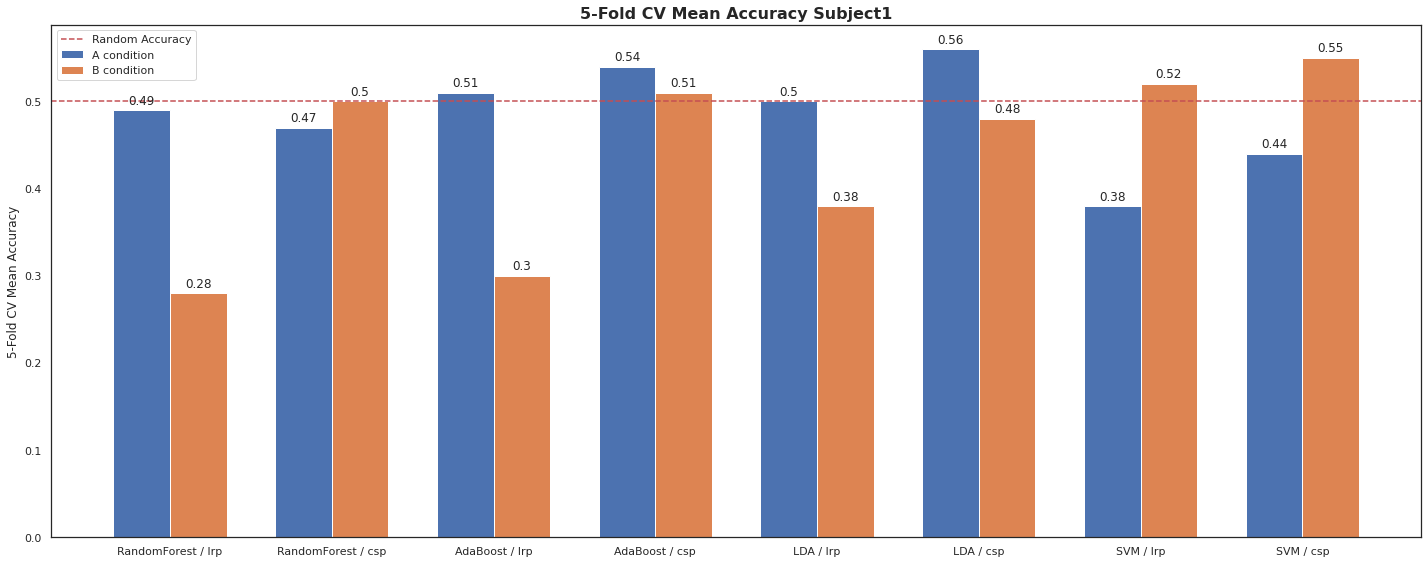

In [68]:
make_barplt(tuned_clfs_s1, subject_number=1, plot_name='ModelAccuracyCV_s1_35HzLowpassFilter_brplt')

Plot stacked density plots for n=200 distribution of accuracy scores

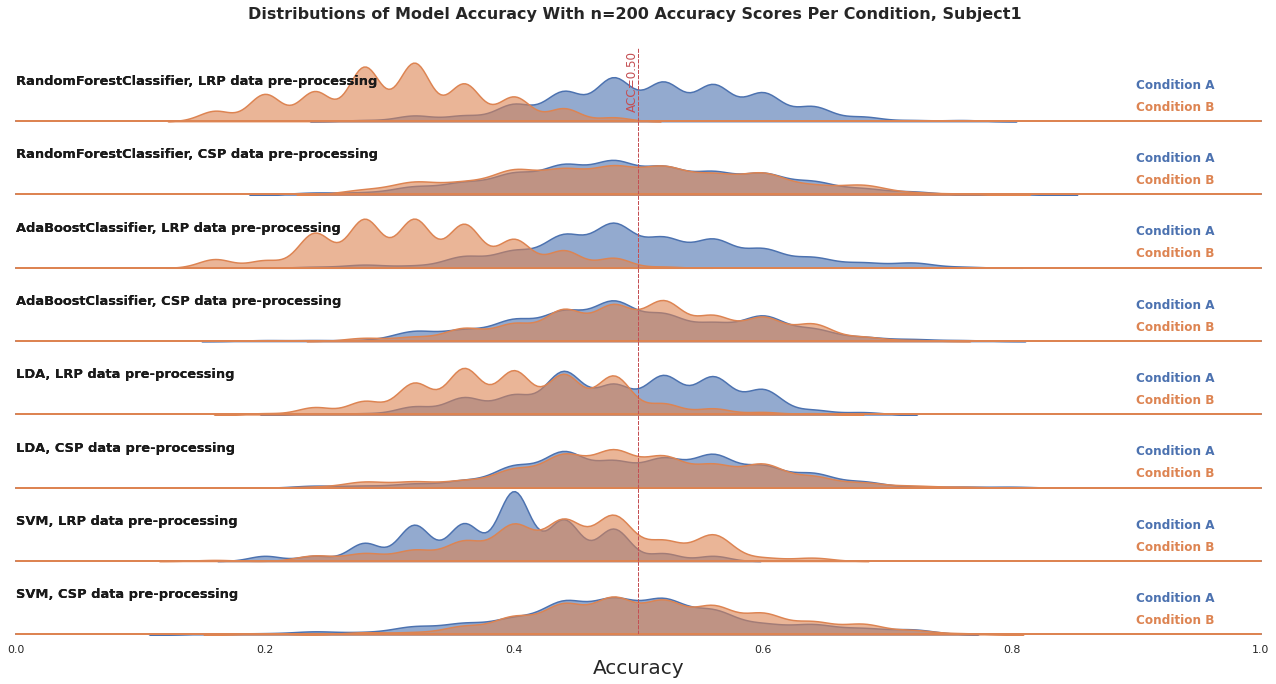

In [69]:
make_overlapping_density(tuned_clfs_s1, subject_number=1, plot_name='ModelAccuracyDist_s1_35HzLowpassFilter_densityplt')

Plot stacked density plots only for models trained and tested on LRP data

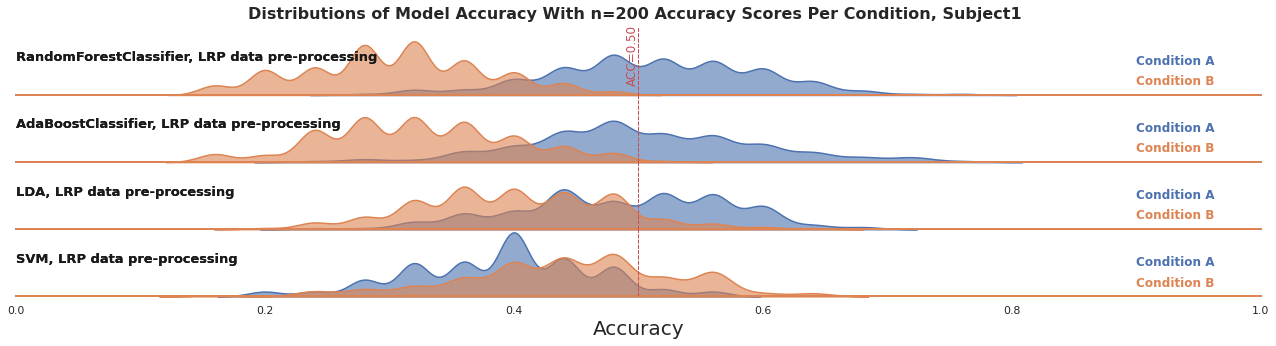

In [70]:
clfs_lrp = [clf for clf in tuned_clfs_s1 if clf['reduction_method']=='lrp']
make_overlapping_density(clfs_lrp, subject_number=1, plot_name='ModelAccuracyLRPdist_s1_35HzLowpassFilter_densityplt')

#### Subject 2 ####

Read in data and pre-process. In this case our data came in a slightly different format, so additional pre-processing is needed to make the data compatible with our functions

In [35]:
data_cube = sio.loadmat('../Data/data_cube_s2.mat')

# Preprocessing

# extract data and labels

data = data_cube['data_cube']
trlsel = data_cube['trlsel']
labels_hand = data_cube['labels_hand']
labels_condition = data_cube['labels_condition']
labels_hand_tokeep = data_cube['labels_hand_tokeep']

# Remove trials in which participant did not press (np)
labels_hand_tokeep_np = labels_hand_tokeep[np.where(trlsel==1),:][1]
np_to_be_removed = np.where(labels_hand_tokeep_np==0)

data_np = np.delete(data,np_to_be_removed[0],2)
trlsel_np = np.delete(trlsel,np_to_be_removed[0],1)
labels_condition_np = np.delete(labels_condition,np_to_be_removed[0],0)

# Remove trials with muscle artifacts (ma)
labels_condition_np_ma = labels_condition_np[np.where(trlsel_np==1),:][1]
labels_hand_ma = labels_hand[np.where(trlsel_np==1),:][1]

# Divide data into condition A and B

data_A = np.delete(data_np, np.where(labels_condition_np_ma==1), 2)
data_B = np.delete(data_np, np.where(labels_condition_np_ma==0), 2)
data_tensor = np.concatenate([data_A, data_B], axis=-1)
labels_A = np.delete(labels_hand_ma, np.where(labels_condition_np_ma==1), 0)
labels_B = np.delete(labels_hand_ma, np.where(labels_condition_np_ma==0), 0)
data_labels = np.concatenate([labels_A, labels_B], axis=0).ravel()
#low pass filter 

def our_lowpass(data, freq=35):
    filt_data = data
    b, a = signal.butter(6, freq, 'low', analog = False, fs = 1000)
    for i in range(len(data)):
        filt_data[i] = signal.filtfilt(b, a, data[i])
    return filt_data


#apply lowpass filter to data
data_tensor = our_lowpass(data_tensor)

Tune Hyperparameters and initialize dictionary list object

In [36]:
%%time
# #Tune hyperparameters.This block takes approximately 2 hours to complete on 7 cores
tuned_clfs_s2 = tune_multiple_models(data_tensor, data_labels, trials_in_A=226)
with open('./bin/clfs_s2.p','wb') as clf_pickle_file:
    pickle.dump(tuned_clfs_s2, clf_pickle_file)

Hyperparameter tuning RandomForestClassifier on data pre-processed by dimensionality reduction method lrp.
	 Done. Wall time elapsed: 2:55:45.142962
Hyperparameter tuning RandomForestClassifier on data pre-processed by dimensionality reduction method csp.
	 Done. Wall time elapsed: 0:06:23.454286
Hyperparameter tuning AdaBoostClassifier on data pre-processed by dimensionality reduction method lrp.
	 Done. Wall time elapsed: 0:44:38.971553
Hyperparameter tuning AdaBoostClassifier on data pre-processed by dimensionality reduction method csp.
	 Done. Wall time elapsed: 0:01:00.290851
Hyperparameter tuning LDA on data pre-processed by dimensionality reduction method lrp.
	 Done. Wall time elapsed: 0:00:20.341402
Hyperparameter tuning LDA on data pre-processed by dimensionality reduction method csp.
	 Done. Wall time elapsed: 0:00:00.068573
Hyperparameter tuning SVM on data pre-processed by dimensionality reduction method lrp.
	 Done. Wall time elapsed: 0:04:14.218273
Hyperparameter tuning 

Tune n_components for CSP dimensionality Reduction

In [42]:
%%time
#This block runs in 45min on 3 cores
tune_csp_args_cv(tuned_clfs_s2, data_tensor, data_labels, n_component_list=list(range(1,64)))
with open('./bin/clfs_s2.p','wb') as clf_pickle_file:
    pickle.dump(tuned_clfs_s2, clf_pickle_file)

CSP n_component tuning using memoization. First classifier will take longer to tune as memoization cache is filled.
Tuning CSP n_components for RandomForestClassifier
	 Done. Best n_components: 1. Best accuracy 0.5721855921855922. Wall time elapsed: 0:40:47.301939
Tuning CSP n_components for AdaBoostClassifier
	 Done. Best n_components: 52. Best accuracy 0.5811721611721612. Wall time elapsed: 0:07:28.377514
Tuning CSP n_components for LDA
	 Done. Best n_components: 37. Best accuracy 0.5610012210012211. Wall time elapsed: 0:06:54.806625
Tuning CSP n_components for SVM
	 Done. Best n_components: 19. Best accuracy 0.5810744810744811. Wall time elapsed: 0:11:25.731371
CPU times: user 3h 5min 6s, sys: 2h 15min 37s, total: 5h 20min 43s
Wall time: 1h 6min 36s


Obtain Accuracy Scores

In [43]:
%%time
dimensionality_reduction_methods = {'lrp': calc_lrp, 'csp': csp_transform}
evaluate_models(tuned_clfs_s2, data_tensor, data_labels, 226, dimensionality_reduction_methods, n_iter=200)
with open('./bin/clfs_s2.p','wb') as clf_pickle_file:
    pickle.dump(tuned_clfs_s2, clf_pickle_file)

Obtaining 5-fold CV accuracy for RandomForestClassifier using reduction method lrp.
	 Done. Wall time elapsed: 0:00:00.387084
Obtaining 200 sample distribution of accuracy scores for RandomForestClassifier using reduction method lrp.
	 Done. Wall time elapsed: 0:00:14.618341
Obtaining 5-fold CV accuracy for RandomForestClassifier using reduction method lrp.
	 Done. Wall time elapsed: 0:00:00.371129
Obtaining 200 sample distribution of accuracy scores for RandomForestClassifier using reduction method lrp.
	 Done. Wall time elapsed: 0:00:14.480815
Obtaining 5-fold CV accuracy for RandomForestClassifier using reduction method csp.
	 Done. Wall time elapsed: 0:00:16.053099
Obtaining 200 sample distribution of accuracy scores for RandomForestClassifier using reduction method csp.
	 Done. Wall time elapsed: 0:10:55.329654
Obtaining 5-fold CV accuracy for RandomForestClassifier using reduction method csp.
	 Done. Wall time elapsed: 0:00:17.305429
Obtaining 200 sample distribution of accuracy 

Plot Barplot for 5-fold CV Accuracy score

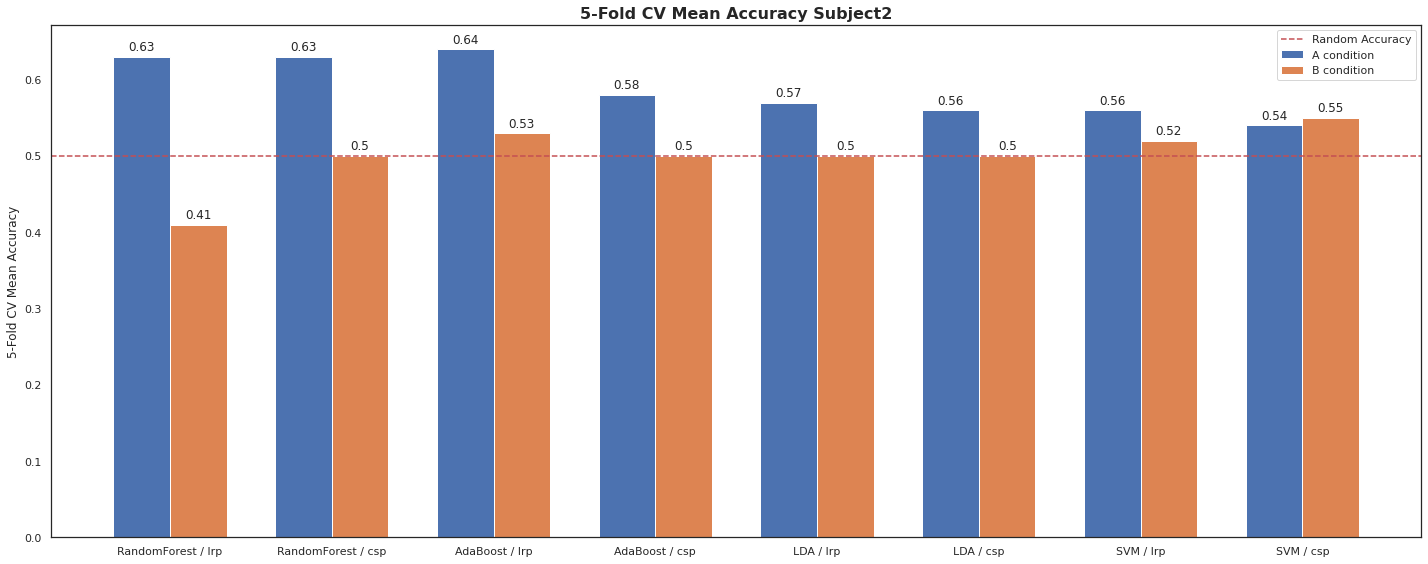

In [71]:
make_barplt(tuned_clfs_s2, subject_number=2, plot_name='ModelAccuracyCV_s2__35HzLowpassFilter_brplt')

Plot stacked density plots for n=200 distribution of accuracy scores

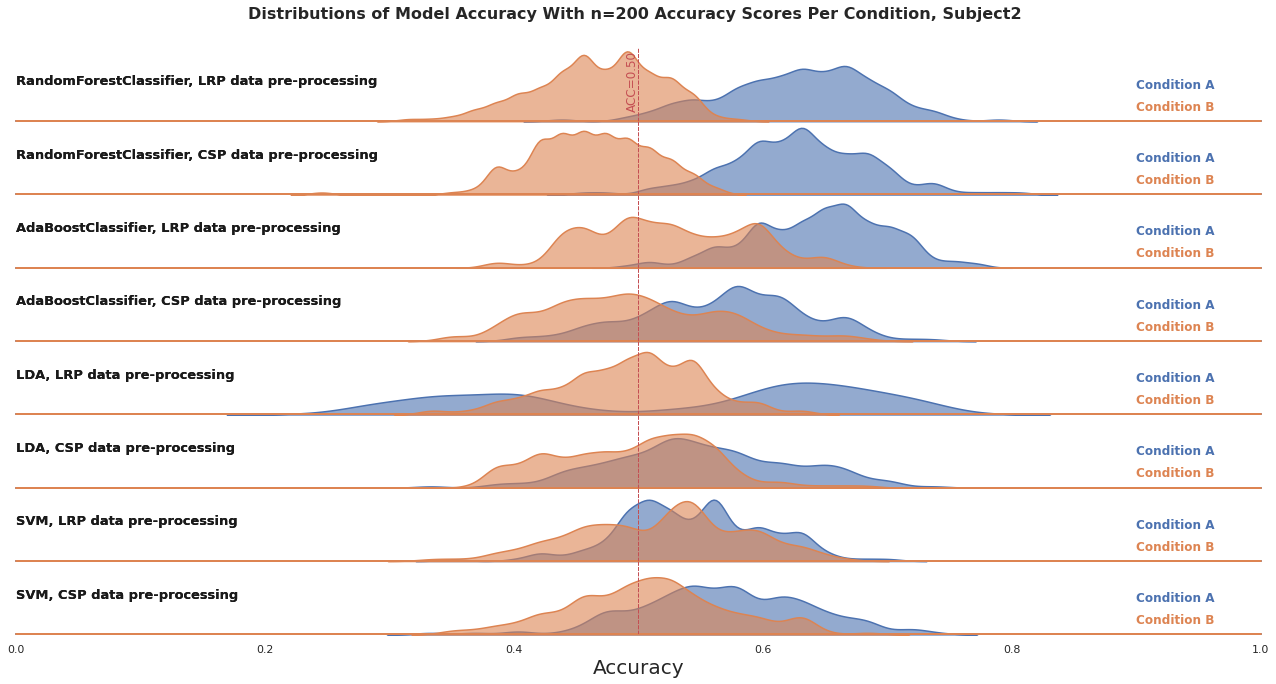

In [72]:
make_overlapping_density(tuned_clfs_s2, subject_number=2, plot_name='ModelAccuracyDist_s2_35HzLowpassFilter_densityplt')

Plot stacked density plots only for models trained and tested on LRP data

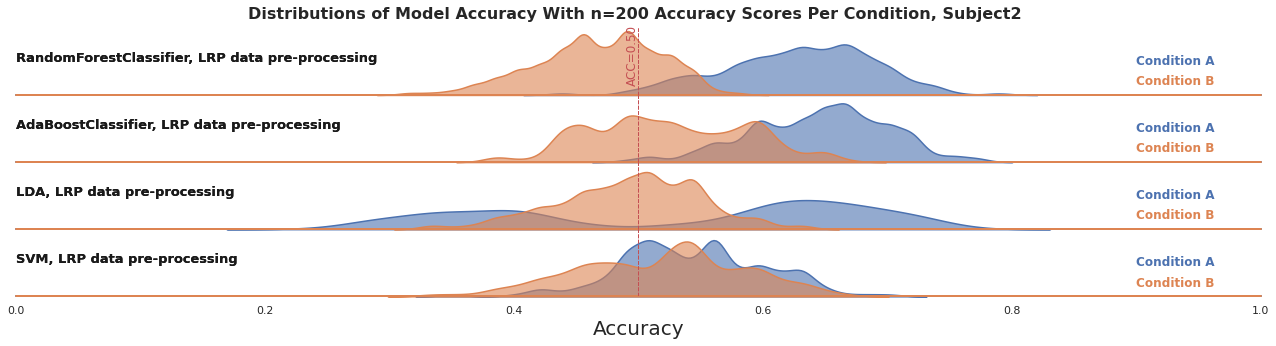

In [73]:
clfs_lrp = [clf for clf in tuned_clfs_s2 if clf['reduction_method']=='lrp']
make_overlapping_density(clfs_lrp, subject_number=2, plot_name='ModelAccuracyLRPdist_s2_35HzLowpassFilter_densityplt')